In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

LARGE_WINDOW_SIZE = 100000
LARGE_WINDOW_FILENAME = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows.bed'

## Make large windows

In [2]:
from shell import shell 

def make_large_windows(): 
  chromosome_sizes = f'{CONSTRAINT_TOOLS_DATA}/reference/grch38/chromosome-sizes/hg38.chrom.sizes.sorted'
  cmd = f'bedtools makewindows -g {chromosome_sizes} -w {LARGE_WINDOW_SIZE} > {LARGE_WINDOW_FILENAME}'    
  shell(cmd)

make_large_windows()

## Get large windows with overlapping deletions

In [3]:
import pandas as pd 
import numpy as np 

def aggregate(df, group_columns, aggregation_functions): 
  groups = df.groupby(group_columns)
  aggregated = groups.agg(aggregation_functions)  
  df = aggregated.reset_index()
  df.columns = [' '.join(col[::-1]).strip() for col in df.columns.values]
  return df

# intersect large windows with deletions (both het and homalt), and filter out suspect large windows
def read_large_windows_intersect_all_deletions():
  cmd = f'bash {CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/intersect-large-windows-with-topmed-deletions-and-filter.sh'
  print(shell(cmd))

  df = pd.read_csv(
    f"{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/filtered-large-windows-with-deletions.bed", 
    sep = '\t',
  )  
  df = df[
    (df['chrom_window'] != 'chrX') &
    (df['chrom_window'] != 'chrY')
  ]

  group_columns = [
    'chrom_window',
    'start_window',
    'end_window',
    'number_of_overlapping_topmed_deletions'
  ]
  aggregation_functions = {
    'window_merged_deletion_overlap': [np.sum],
  }
  aggregation_columns = list(aggregation_functions.keys())
  new_columns = group_columns + aggregation_columns
  df = df[new_columns]
  df = aggregate(df, group_columns, aggregation_functions)
  
  df = df.rename(columns = {
    'chrom_window': 'chrom',
    'start_window': 'start',
    'end_window': 'end',
    'sum window_merged_deletion_overlap': 'large_window-merged_deletion overlap'
  })

  df.to_csv(
    f"{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/filtered-large-windows-with-deletions.aggregated.bed", 
    sep = '\t',
    index = False
  )
  
  return df 
  
pd.set_option('display.max_rows', 1000)

LARGE_WINDOWS = read_large_windows_intersect_all_deletions()
LARGE_WINDOWS

Wrote (filtered) large windows with intersecting topmed deletions to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/filtered-large-windows-with-deletions.bed



,chrom,start,end,number_of_overlapping_topmed_deletions,large_window-merged_deletion overlap
0,chr1,2300000,2400000,13,68415
1,chr1,2400000,2500000,9,78531
2,chr1,2500000,2600000,8,25337
3,chr1,2600000,2700000,10,41796
4,chr1,2800000,2900000,15,69123
...,...,...,...,...,...
24980,chr9,133900000,134000000,31,99485
24981,chr9,134000000,134100000,7,100000
24982,chr9,134200000,134300000,14,87922
24983,chr9,134300000,134400000,6,17742


## Get small windows, with enhancer, exon, and Chen variables

In [4]:
def compute_N_mean_null_chen(row): 
  a = 1 
  b = -(2*row['N_observed'] + row['new chen zscore']**2)
  c = row['N_observed']**2
  sqrt = np.sqrt(b**2 - 4*a*c)
  sign = 1 if row['new chen zscore'] > 0 else -1
  return (-b + sign*sqrt)/(2*a)
  
def get_small_windows():
  # this bed file has already been aggregated to the window level: 
  # experiments/germline-model/chen-et-al-2022/enhancer-characteristics-enrichment.ipynb 
  filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment.bed'
  df = pd.read_csv(filename, sep='\t')
  df = df[[
    'chromosome', 'start', 'end',
    'window overlaps merged_exon',
    'window overlaps enhancer',
    'window overlaps cpg_island',
    'new chen zscore',
    'negative new chen zscore',
    'N_observed',
    'enhancer count',
    'window_enhancer_overlap_bps sum',
  ]]

  df['N_mean_null_chen'] = df.apply(compute_N_mean_null_chen, axis=1)
  df['N_variance_null_chen'] = df['N_mean_null_chen'] # assume poisson distribution

  df = df.rename(columns={
    'chromosome': 'chrom', 
  }) # type: ignore

  df.to_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/small-windows.bed', 
    sep='\t',
    index=False
  )

  return df 

pd.set_option('display.max_columns', 100)

SMALL_WINDOWS = get_small_windows()
SMALL_WINDOWS

,chrom,start,end,window overlaps merged_exon,window overlaps enhancer,window overlaps cpg_island,new chen zscore,negative new chen zscore,N_observed,enhancer count,window_enhancer_overlap_bps sum,N_mean_null_chen,N_variance_null_chen
0,chr1,1432000,1433000,False,True,False,4.299894,-4.299894,260,1,1000,339.191842,339.191842
1,chr1,1435000,1436000,True,True,True,3.331645,-3.331645,275,1,1000,336.077060,336.077060
2,chr1,1449000,1450000,True,False,False,1.817267,-1.817267,225,0,0,253.960193,253.960193
3,chr1,1450000,1451000,True,False,False,1.365863,-1.365863,313,0,0,338.115367,338.115367
4,chr1,1451000,1452000,False,False,False,0.666316,-0.666316,293,0,0,304.629643,304.629643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785815,chr9,137269000,137270000,False,True,False,5.276351,-5.276351,210,1,1000,301.638272,301.638272
1785816,chr9,137275000,137276000,False,True,False,2.687348,-2.687348,296,2,712,345.986596,345.986596
1785817,chr9,137282000,137283000,True,True,False,-0.090791,0.090791,211,1,572,209.685294,209.685294
1785818,chr9,137290000,137291000,False,False,False,2.162811,-2.162811,224,0,0,258.793251,258.793251


## Intersect large windows with small windows, group by large window, aggregate over enhancer, exon, and Chen columns to compute chen score per large window


In [5]:
def intersect_large_with_small():
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/filtered-large-windows-with-deletions.aggregated.bed)"
    f" -b <(tail -n +2 {CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/small-windows.bed)"
    f' -wao'
    f' > {CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-intersect-small-windows.bed'
  )
  shell(cmd)

  df = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-intersect-small-windows.bed', 
    sep='\t',
    names=[
      'chrom_large', 'start_large', 'end_large', 'number_of_overlapping_topmed_deletions', 'large_window-merged_deletion overlap',
      'chrom_small', 'start_small', 'end_small', 'small_window overlaps merged_exon', 'small_window overlaps enhancer', 'small_window overlaps cpg_island', 'new chen zscore', 'negative new chen zscore', 'N_observed', 'enhancer count', 'small_window_enhancer_overlap_bps sum', 'N_mean_null_chen', 'N_variance_null_chen', 'large_window-small_window overlap'
    ],
  )

  df = df[df['chrom_small'] != '.'] # we don't want to include large windows that don't overlap any small windows

  # Define the data types of the columns
  dtypes = {
    'chrom_large': str, 
    'start_large': int, 
    'end_large': int, 
    'number_of_overlapping_topmed_deletions': int, 
    'large_window-merged_deletion overlap': int,
    'chrom_small': str, 
    'start_small': int, 
    'end_small': int, 
    'small_window overlaps merged_exon': str, 
    'small_window overlaps enhancer': str, 
    'small_window overlaps cpg_island': str, 
    'new chen zscore': float, 
    'negative new chen zscore': float, 
    'N_observed': int, 
    'enhancer count': int, 
    'small_window_enhancer_overlap_bps sum': int, 
    'N_mean_null_chen': float, 
    'N_variance_null_chen': float, 
    'large_window-small_window overlap': int
  }
  for col, dtype in dtypes.items(): 
    df[col] = df[col].astype(dtype)

  for col in [
    'small_window overlaps merged_exon', 
    'small_window overlaps enhancer', 
    'small_window overlaps cpg_island'
  ]:  
    df[col] = df[col].apply(lambda x: x == 'True')

  print(df.dtypes)

  group_columns = [
    'chrom_large', 'start_large', 'end_large', 'number_of_overlapping_topmed_deletions', 'large_window-merged_deletion overlap',
  ]
  aggregation_functions = {
    'small_window overlaps merged_exon': [np.sum], 
    'small_window overlaps enhancer': [np.sum], 
    'small_window overlaps cpg_island': [np.sum], 
    'N_observed': [np.sum], 
    'enhancer count': [np.sum], 
    'small_window_enhancer_overlap_bps sum': [np.sum], 
    'N_mean_null_chen': [np.sum],
    'N_variance_null_chen': [np.sum], 
    'large_window-small_window overlap': [np.sum],
    'negative new chen zscore': [np.min] 
  }
  aggregation_columns = list(aggregation_functions.keys())
  new_columns = group_columns + aggregation_columns
  df = df[new_columns]
  df = aggregate(df, group_columns, aggregation_functions)

  df['negative new chen zscore'] = (df['sum N_observed'] - df['sum N_mean_null_chen'])/np.sqrt(df['sum N_variance_null_chen'])
  
  return df 

LARGE_WINDOWS = intersect_large_with_small()
LARGE_WINDOWS

<ipython-input-5-1911d0bb4ee2>:80: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  LARGE_WINDOWS = intersect_large_with_small()


chrom_large                                object
start_large                                 int64
end_large                                   int64
number_of_overlapping_topmed_deletions      int64
large_window-merged_deletion overlap        int64
chrom_small                                object
start_small                                 int64
end_small                                   int64
small_window overlaps merged_exon            bool
small_window overlaps enhancer               bool
small_window overlaps cpg_island             bool
new chen zscore                           float64
negative new chen zscore                  float64
N_observed                                  int64
enhancer count                              int64
small_window_enhancer_overlap_bps sum       int64
N_mean_null_chen                          float64
N_variance_null_chen                      float64
large_window-small_window overlap           int64
dtype: object


,chrom_large,start_large,end_large,number_of_overlapping_topmed_deletions,large_window-merged_deletion overlap,sum small_window overlaps merged_exon,sum small_window overlaps enhancer,sum small_window overlaps cpg_island,sum N_observed,sum enhancer count,sum small_window_enhancer_overlap_bps sum,sum N_mean_null_chen,sum N_variance_null_chen,sum large_window-small_window overlap,min negative new chen zscore,negative new chen zscore
0,chr1,2300000,2400000,13,68415,21,13,7,8177,14,9337,9794.714649,9794.714649,31000,-6.254506,-16.345794
1,chr1,2400000,2500000,9,78531,4,4,1,3093,4,1798,3866.251388,3866.251388,13000,-6.184123,-12.435855
2,chr1,2500000,2600000,8,25337,22,21,11,7172,24,17979,9340.543817,9340.543817,28000,-8.252822,-22.437895
3,chr1,2600000,2700000,10,41796,5,2,0,3669,2,1037,4376.598388,4376.598388,18000,-5.443687,-10.695928
4,chr1,2800000,2900000,15,69123,3,6,0,6183,6,2048,7225.712275,7225.712275,25000,-4.825689,-12.266599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24628,chr9,133900000,134000000,31,99485,3,25,3,7476,27,19573,9422.773366,9422.773366,32000,-5.783680,-20.055155
24629,chr9,134000000,134100000,7,100000,11,11,2,7910,12,6989,9103.134739,9103.134739,37000,-5.149057,-12.505297
24630,chr9,134200000,134300000,14,87922,5,25,0,10653,27,18569,13194.622097,13194.622097,47000,-5.052936,-22.126489
24631,chr9,134300000,134400000,6,17742,1,18,2,5128,21,13587,6424.429486,6424.429486,22000,-6.073125,-16.174528


## Deletion density differentiates constrained from unconstrained regions


sum small_window overlaps merged_exon min and max: 0, 80
average score for 0-10: 11.856421296679638
average score for 10-20: 9.169856023327865
average score for 20-100: 7.869577155409116


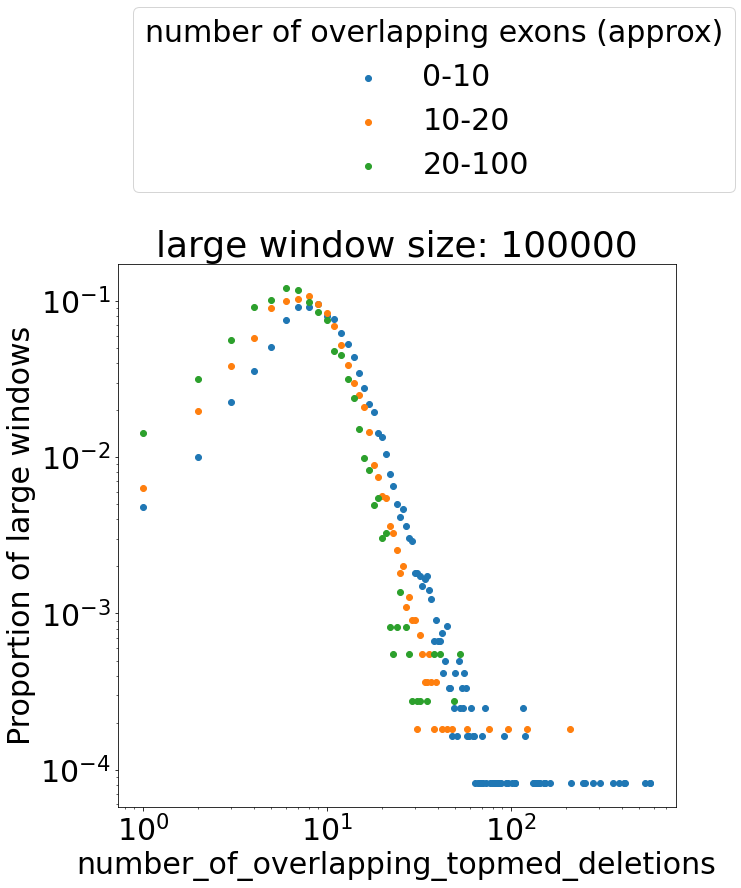

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30

def plot_score_distribution(df, score, condition_label): 
  print(f'average score for {condition_label}: {np.mean(np.array(df[score]))}')

  ser = df[score].value_counts()
  unique_scores = np.array(ser.index)
  window_counts = np.array(ser)
  total_number_windows = np.sum(window_counts)
  probs = window_counts / total_number_windows

  plt.scatter(unique_scores, probs, label=condition_label)

def plot_score_distributions(df, score, condition, condition_bins, condition_labels, legend_title, xscale='log', yscale='log', plot_function=plot_score_distribution): 
  df = df.copy()

  print(f'{condition} min and max: {np.min(df[condition])}, {np.max(df[condition])}')

  df[f'{condition} bins'] = pd.cut(df[condition], bins=condition_bins, labels=condition_labels)

  for condition_label in condition_labels: 
    plot_function(
      df[df[f'{condition} bins'] == condition_label], 
      score, 
      condition_label
    )
  plt.xlabel(score)
  plt.ylabel('Proportion of large windows')
  plt.xscale(xscale) # type: ignore
  plt.yscale(yscale) # type: ignore

  legend_bbox = (0, 1.5)
  legend_loc = 'upper left'
  (
    plt
      .legend(bbox_to_anchor=legend_bbox, loc=legend_loc)
      .set_title(legend_title)
  )

  plt.title(f'large window size: {LARGE_WINDOW_SIZE}')
  fig = plt.gcf()
  fig.set_size_inches(10, 10)

plot_score_distributions(
  LARGE_WINDOWS,
  score='number_of_overlapping_topmed_deletions',
  condition='sum small_window overlaps merged_exon', 
  condition_bins=[0, 10, 20, 100],
  condition_labels=['0-10', '10-20', '20-100'],
  legend_title='number of overlapping exons (approx)'
)

sum small_window overlaps enhancer min and max: 0, 72
average score for 0-10: 15.543286677034732
average score for 10-20: 13.00139470013947
average score for 20-100: 10.475


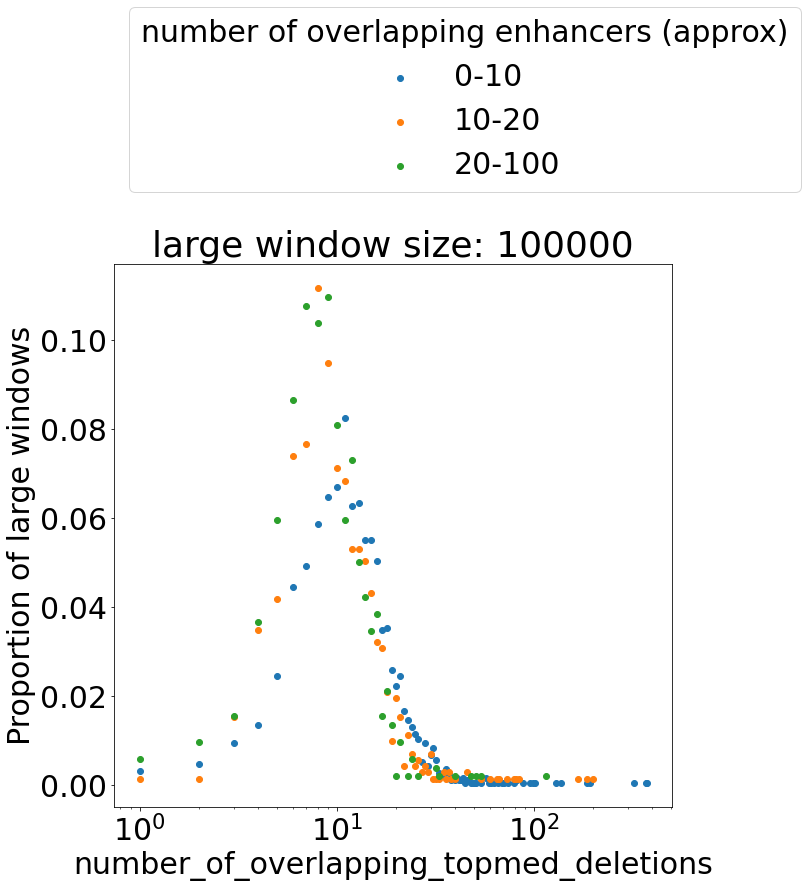

In [31]:
plot_score_distributions(
  LARGE_WINDOWS[LARGE_WINDOWS['sum small_window overlaps merged_exon'] == 0],
  score='number_of_overlapping_topmed_deletions',
  condition='sum small_window overlaps enhancer', 
  condition_bins=[0, 10, 20, 100],
  condition_labels=['0-10', '10-20', '20-100'],
  legend_title='number of overlapping enhancers (approx)',
  yscale='linear'
)

sum small_window_enhancer_overlap_bps sum min and max: 0, 60238
average score for 0-10kb: 14.984107579462103
average score for 10-20kb: 11.646817248459959
average score for 20-65kb: 10.262222222222222


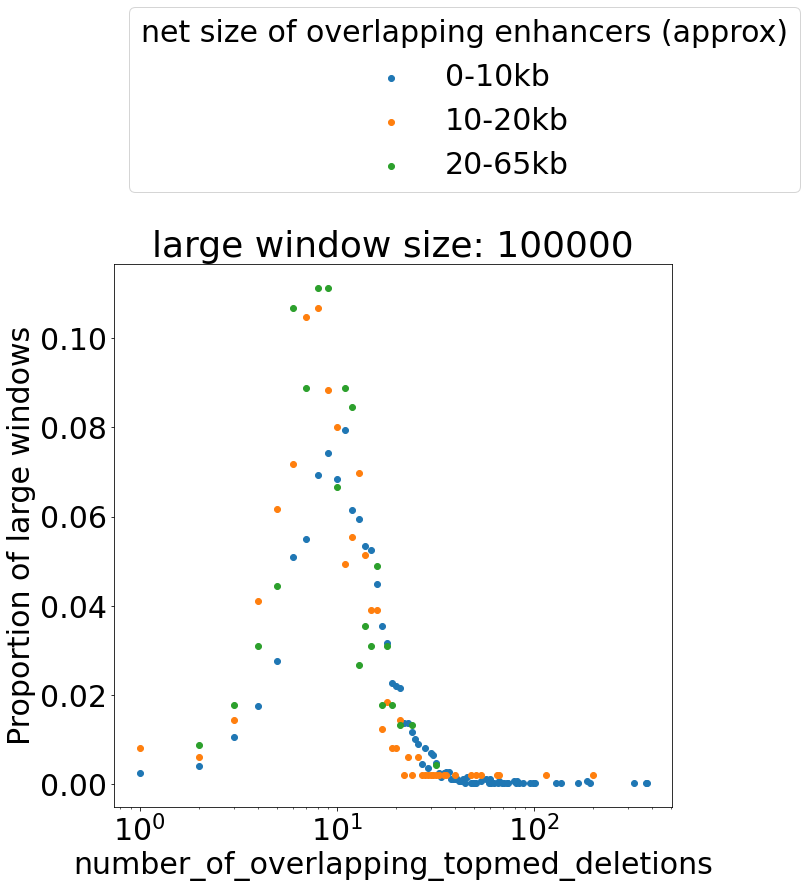

In [32]:
plot_score_distributions(
  LARGE_WINDOWS[LARGE_WINDOWS['sum small_window overlaps merged_exon'] == 0],
  score='number_of_overlapping_topmed_deletions',
  condition='sum small_window_enhancer_overlap_bps sum', 
  condition_bins=[0, 10000, 20000, 65000],
  condition_labels=['0-10kb', '10-20kb', '20-65kb'],
  legend_title='net size of overlapping enhancers (approx)',
  yscale='linear'
)

## Deletion overlap differentiates constrained from unconstrained regions


sum small_window overlaps merged_exon min and max: 0, 80
average score for 0-10: 76816.23143164693
average score for 10-20: 65643.03973027156
average score for 20-100: 58320.74903898957


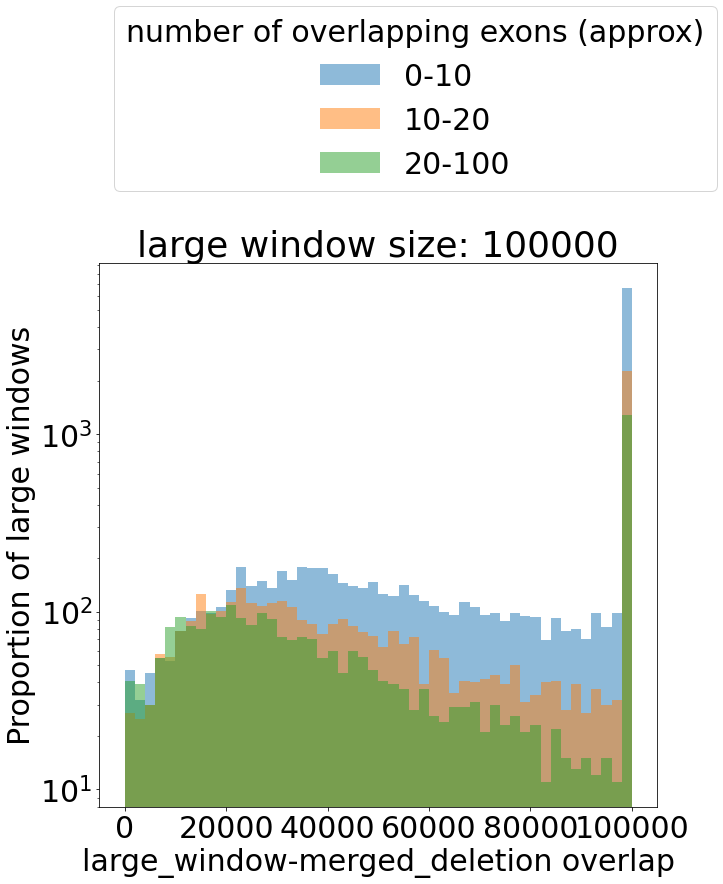

In [40]:
def plot_score_distribution2(df, score, condition_label): 
  print(f'average score for {condition_label}: {np.mean(np.array(df[score]))}')
  plt.hist(df[score], bins=50, label=condition_label, alpha=0.5)

plot_score_distributions(
  LARGE_WINDOWS,
  score='large_window-merged_deletion overlap',
  condition='sum small_window overlaps merged_exon', 
  condition_bins=[0, 10, 20, 100],
  condition_labels=['0-10', '10-20', '20-100'],
  legend_title='number of overlapping exons (approx)',
  plot_function=plot_score_distribution2,
  xscale='linear',
  yscale='log'
)

## Min Negative Chen score differentiates constrained from unconstrained regions


sum small_window overlaps merged_exon min and max: 0, 80
average score for 0-10: 1.277993143634679
average score for 10-20: -4.859936104832418
average score for 20-100: -9.26198267023092


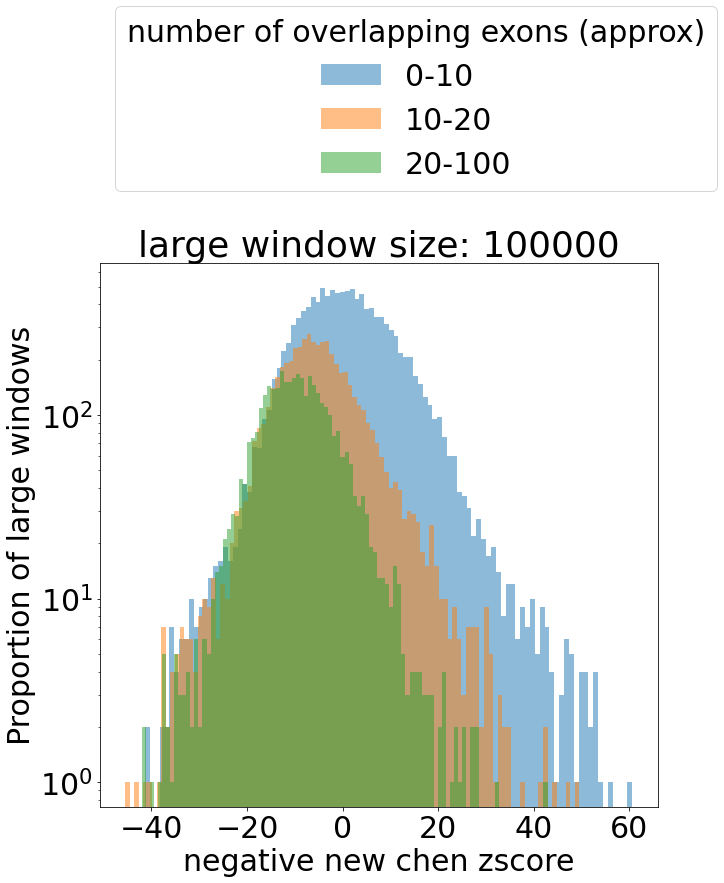

In [34]:
def plot_score_distribution3(df, score, condition_label): 
  print(f'average score for {condition_label}: {np.mean(np.array(df[score]))}')
  plt.hist(df[score], bins=100, label=condition_label, alpha=0.5)

plot_score_distributions(
  LARGE_WINDOWS,
  score='negative new chen zscore',
  condition='sum small_window overlaps merged_exon', 
  condition_bins=[0, 10, 20, 100],
  condition_labels=['0-10', '10-20', '20-100'],
  legend_title='number of overlapping exons (approx)',
  plot_function=plot_score_distribution3,
  xscale='linear',
  yscale='log'
)

sum small_window overlaps merged_exon min and max: 0, 80
average score for 0-10: -2.6943264613987172
average score for 10-20: -3.6490916704621834
average score for 20-100: -4.397144957346413


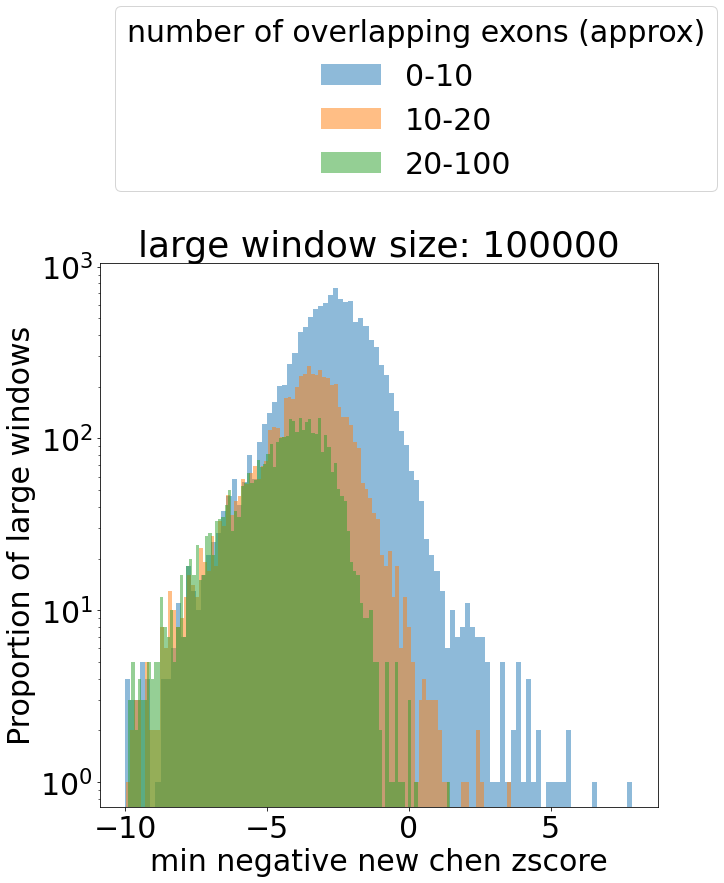

In [35]:
plot_score_distributions(
  LARGE_WINDOWS,
  score='min negative new chen zscore',
  condition='sum small_window overlaps merged_exon', 
  condition_bins=[0, 10, 20, 100],
  condition_labels=['0-10', '10-20', '20-100'],
  legend_title='number of overlapping exons (approx)',
  plot_function=plot_score_distribution3,
  xscale='linear',
  yscale='log'
)

## There is a mild correlation between deletion density and various versions of SNV density 

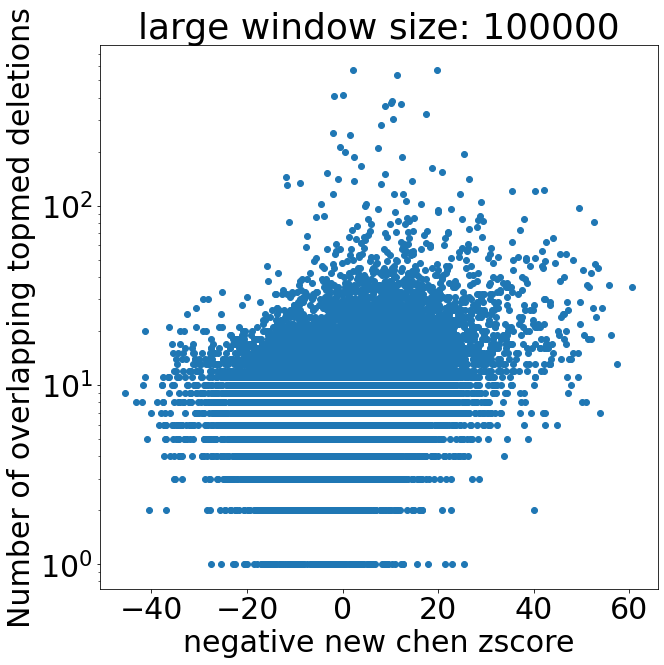

In [44]:
def plot_deletion_density_against_chen_score(df, chen_score):
  plt.scatter(df[chen_score], df['number_of_overlapping_topmed_deletions'])
  # plt.scatter(df[chen_score], df['large_window-merged_deletion overlap'])  
  plt.yscale('log')
  plt.xlabel(chen_score)
  plt.ylabel('Number of overlapping topmed deletions')
  plt.title(f'large window size: {LARGE_WINDOW_SIZE}')
  fig = plt.gcf()
  fig.set_size_inches(10, 10)

plot_deletion_density_against_chen_score(LARGE_WINDOWS, 'negative new chen zscore')

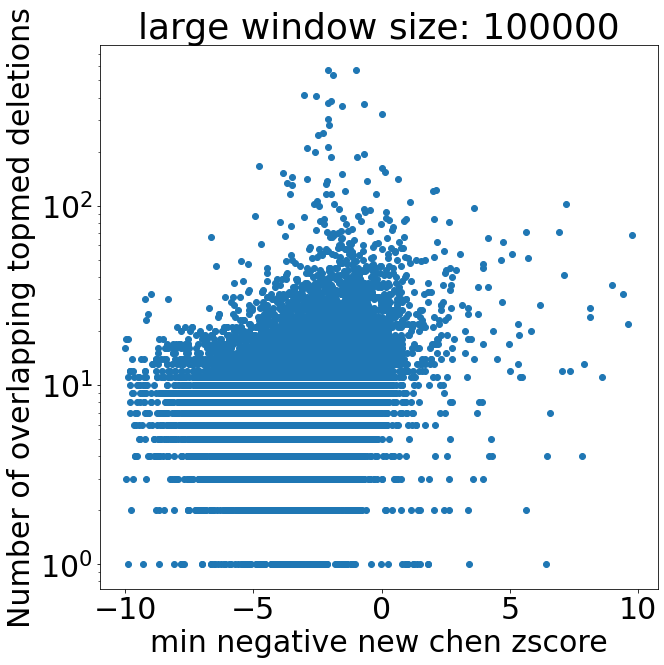

In [45]:
plot_deletion_density_against_chen_score(LARGE_WINDOWS, 'min negative new chen zscore')